## CNN Model with Image Augmentation: Detecting Cataracts
This is the same as the Image Augmentation CNN model used on eyes with Glaucoma, applied to eyes with Cataracts.

The only change made to the model was to adjust the EarlyStopping callback so that the model would run for additional epochs.

This notebook includes some code comments and markdown explanations, but the notebook for the Glaucoma model has more robust commenting that is not repeated here if it would be the same.

### Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# Setting a random seed for reproducibility
np.random.seed(42)

### Reading in image data as X and y

In [3]:
# specify the path with the subfolders of cleaned eye images
clean_path = './cleaned_eye_images/'

# make a dictionary of eye conditions and integers because y needs to be a number, not a string
# setting the condition to be 1 so that 'positive' results mean the eye has the condition
condition_dict = {'cataracts':1, 'normal': 0}

# make empty lists for X and y
X=[]
y=[]

# iterate through each subfolder (= condition)
for condition in os.listdir(clean_path):
    
    # make sure the subfolder is actually the name of a condition (e.g., not 'DS_Store')
    if condition in condition_dict.keys():
        
        # allows you to specify how many images to collect from each folder
        # this allows the final number to be divisible by the desired batch size
        number=0
        total_num = 468
        
        # iterate through each image file in the subfolder
        for file in os.listdir(clean_path+condition):
            
            if number < total_num:
            
            # added a try/except so that DS_Store files don't trip an error
                try:
                    # load the image file
                    image = load_img(clean_path+condition+'/'+file)
                   
                    # turn the image into an array
                    image_arr = img_to_array(image)
                
                    # add the image array to X
                    X.append(image_arr)
                
                    # use the condition_dict to add the right number to y that corresponds to the eye condition
                    y.append(condition_dict[condition])
                    
                    number+=1
                
                except:
                    continue

In [4]:
# change X and y into numpy arrays
X = np.array(X)
y = np.array(y)

In [5]:
# checking the shape of X
# there are 768 512x512 images with 3 channels (RGB)
X.shape

(768, 512, 512, 3)

In [6]:
# y matches the number of images in X
y.shape

(768,)

### Baseline Model
Our dataset is unevenly distributed between normal eyes and eyes with cataracts, and the model needs to make correct predictions more than 60.9% of the time to beat the baseline.

In [7]:
print(f'There are {len(y)-y.sum()} non-diseased eye images and {y.sum()} images of eyes with cataracts in the dataset.')

# Since y is binary with values of 0 and 1, the baseline accuracy can be found by summing y and dividing by the length of y
# The baseline accuracy is the higher of this value and 1 - this value
# rounding the numbers to 3 places to make the formatting nicer
print(f'This gives a baseline accuracy of {round(np.array([(y.sum() / len(y)),(1-(y.sum()/len(y)))]).max(), 3)}')

There are 300 non-diseased eye images and 468 images of eyes with cataracts in the dataset.
This gives a baseline accuracy of 0.609


### Train-Test Split

In [8]:
# regular train-test-split 
# no need for StandardScaler because the images have already been normalized

# changed test_size to 128 so test and train sizes are both divisible by 64, the batch_size
# to use with image augmentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=128, random_state=42, stratify=y)

In [9]:
X_train.shape

(640, 512, 512, 3)

### Image Augmentation 

In [10]:
# creating the same ImageDataGenerators as the ones made in the Glaucoma model

image_generator_train = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, rotation_range=30, brightness_range=(.8,1.2))
image_generator_test = ImageDataGenerator(rescale=1.0/255.0)
image_generator_train.fit(X_train)

### Building the CNN Model

In [11]:
# Instantiate a Sequential model (that will process each layer sequentially)
model = Sequential()

In [12]:
# add a Convolutional 2D layer that will create 16 3x3 filters to detect image features

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(512,512,3)))

In [13]:
# add a MaxPooling 2D layer that will take the maximum value in every 2x2 grid (with a stride defaulting to the pool_size)
# this effectively cuts the dimensions of the data in half, and helps get rid of noise caused by small variations in the image

model.add(MaxPooling2D(pool_size=(2,2)))

In [14]:
# add more convolutional layers (with max pooling between each one) 

# increasing filters to 32
# input shape is only needed for the first layer above
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# increasing filters to 64
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

In [15]:
# add a flatten layer to bridge between the convolutional layers and the dense layers
model.add(Flatten())

In [16]:
# the dense layers analyze the features that were identified in the convolutional layers 
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

In [17]:
# add the output layer with sigmoid activatin since it's a binary classification
model.add(Dense(1, activation='sigmoid'))

In [18]:
# compile the model using binary_crossentropy, accuracy metrics, and the adam optimizer
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

### Fitting the Model

The model is the same as the model used for glaucoma and diabetic retinopathy, with the minor adjustment of altering the min_delta of the EarlyStopping callback so that the model would run for more epochs. This was done because the other two models appeared to stop too early -- the models were not improving much, but they also weren't overfit and it was unclear if the model could still improve with more training.

In [19]:
# add early stopping

# changing the min_delta to .001 instead of .01 to see what happens when the model doesn't stop so early
# this is the only change between this model and the Glaucoma and Diabetic Retinopathy models (aside from the inputs)

early_stop = EarlyStopping(monitor='val_loss', min_delta=.001, patience=5, verbose=1, mode='auto')

In [28]:
# fit the model and save it as h so the accuracy and loss scores for each epoch can be visualized

# use a batch size be divisible by the number of images in X_train
h = model.fit(image_generator_train.flow(X_train, y_train, batch_size=32), validation_data=(image_generator_test.flow(X_test, y_test, batch_size=32)), steps_per_epoch=len(X_train)/32, epochs=30, callbacks=[early_stop])

Epoch 1/30
20/20 [==============================] - 132s 6s/step - loss: 0.5068 - accuracy: 0.7203 - val_loss: 0.4036 - val_accuracy: 0.7734
Epoch 2/30
20/20 [==============================] - 117s 6s/step - loss: 0.3361 - accuracy: 0.8734 - val_loss: 0.2761 - val_accuracy: 0.8984
Epoch 3/30
20/20 [==============================] - 107s 5s/step - loss: 0.2490 - accuracy: 0.9000 - val_loss: 0.2250 - val_accuracy: 0.9375
Epoch 4/30
20/20 [==============================] - 107s 5s/step - loss: 0.2056 - accuracy: 0.9156 - val_loss: 0.1787 - val_accuracy: 0.9375
Epoch 5/30
20/20 [==============================] - 109s 5s/step - loss: 0.2014 - accuracy: 0.9156 - val_loss: 0.1754 - val_accuracy: 0.9297
Epoch 6/30
20/20 [==============================] - 111s 5s/step - loss: 0.1916 - accuracy: 0.9250 - val_loss: 0.1844 - val_accuracy: 0.9297
Epoch 7/30
20/20 [==============================] - 107s 5s/step - loss: 0.2002 - accuracy: 0.9266 - val_loss: 0.1705 - val_accuracy: 0.9141
Epoch 8/30
20

This model stops early after 21 epochs (more than double the number of epochs the other disease models trained on, when the EarlyStopping callback was set to a higher min_delta). It achieved the highest training and testing accuracy out of the 3 models, with 94% and 93% respectively. It is also the only model to end with a higher training accuracy than testing accuracy, which is desirable because it suggests the model may be moving toward being overfit and that the limits of the model's ability to improve may have been reached. However, the training and testing accuracy hovered around the 91-94% range for most of training, so the higher number of epochs didn't really improve model performance.

### Saving the Model

In [136]:
# code to save the model as an h5 file so that it can be used in Flask

# commenting out the code so it doesn't run again by accident
#model.save('cataracts_image_aug_model.h5')

### Visualizing the accuracy and loss scores for each epoch

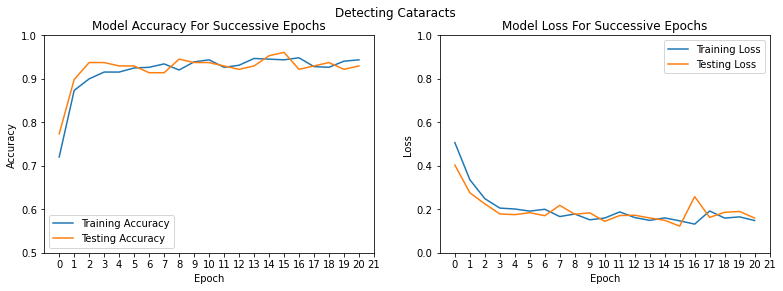

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(13,4))

fig.suptitle('Detecting Cataracts')

# plot training and testing accuracy
axs[0].plot(h.history['accuracy'], label='Training Accuracy')
axs[0].plot(h.history['val_accuracy'], label='Testing Accuracy')

# add titles, labels, and tick formatting 
axs[0].set_title('Model Accuracy For Successive Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(ticks=range(0,22))
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(.5,1)

# add a legend
axs[0].legend()

# plot training and testing loss
axs[1].plot(h.history['loss'], label='Training Loss')
axs[1].plot(h.history['val_loss'], label='Testing Loss')

# add titles, labels, and tick formatting
axs[1].set_title('Model Loss For Successive Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_xticks(ticks=range(0,22))
axs[1].set_ylabel('Loss')
axs[1].set_ylim(0,1)

# add a legend
axs[1].legend();


These plots have the expected shapes, with the highest accuracy increases and loss decreases during the first 2-3 epochs and then a flattening out of scores. The model is not overfit, but does not seem likely to improve beyond the scores obtained in the last epoch. Training the model on additional images (using new images rather than images generated through image augmentation) might improve the scores.

### Making a Confusion Matrix

In [44]:
# generate predictions from X_test
# in order to generate predictions correctly, the X_test images need to be fed to model.predict through
# image_generator_test with shuffle set to False
preds = model.predict(image_generator_test.flow(X_test, shuffle=False))

In [45]:
# change predictions from probabilities to 0s and 1s
preds = [int(np.round(x)) for x in preds]

In [46]:
print(preds)

[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]


In [47]:
y_test

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [51]:
y_test.sum()

78

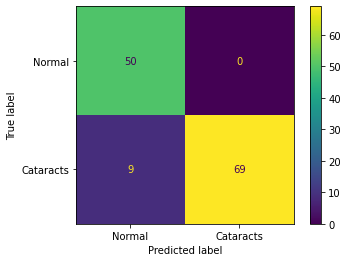

In [58]:
# make and display a confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Cataracts']).plot();

In [59]:
# display the classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        50
           1       1.00      0.88      0.94        78

    accuracy                           0.93       128
   macro avg       0.92      0.94      0.93       128
weighted avg       0.94      0.93      0.93       128



This model achieved the same testing accuracy as the Diabetic Retinopathy model, at 93%. However, as with the Glaucoma model, this Cataract model achieved a 100% specificity rate, with a lower sensitivity rate. The 88.5% sensitivity rate is undesirable for a model designed to diagnose medical conditions because it means a number of the cataracts went undetected. The model is not yet suitable for deployment as a diagnostic tool.

### Conclusions

This model achieved pretty good results, matching the overall accuracy of the Diabetic Retinopathy model. However, the model does not have a high enough sensitivity rate and overall accuracy to be used in a diagnostic setting. The model was trained on very few images, and additional training data could bring the model's performance up to a level that would make it deployable.